In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.cross_validation import cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error

/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train = pd.read_csv('../input/train_processed.csv')
test = pd.read_csv('../input/test_processed.csv')

In [3]:
target = train['Item_Outlet_Sales']
train = train.drop('Item_Outlet_Sales', axis=1)

Label encoding data

In [4]:
for f in train.columns.values:
    if train[f].dtype == 'object':
        print f
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

Item_Fat_Content
Outlet_Identifier
Outlet_Size
Outlet_Location_Type
Outlet_Type
MRP_Level
Item_Type_Combined
Item_Outlet_Category


In [5]:
train.Outlet_Identifier.value_counts()

5    935
1    932
6    930
9    930
8    930
7    929
3    928
2    926
0    555
4    528
Name: Outlet_Identifier, dtype: int64

In [6]:
test.Outlet_Identifier.value_counts()

5    624
1    621
6    620
9    620
8    620
7    619
3    618
2    617
0    370
4    352
Name: Outlet_Identifier, dtype: int64

Based on above two distributions of Outlet_Identifier, train and test datasets are split by Outlet_Identifier. As validation should always correspond to the test dataset. Splitting train by Outlet_Identifier for validation.

In [7]:
(pd.concat([train['Item_MRP'], test['Item_MRP']], ignore_index=True)).describe()

count    14204.000000
mean       141.004977
std         62.086938
min         31.290000
25%         94.012000
50%        142.247000
75%        185.855600
max        266.888400
Name: Item_MRP, dtype: float64

Splitting MRP_Level as distinguishable ordered levels

In [8]:
train['MRP_Level'] = train['MRP_Level'].astype(str).replace({'0':'30', '1':'90', '2':'140', '3':'180'}).astype(int)
test['MRP_Level'] = test['MRP_Level'].astype(str).replace({'0':'30', '1':'90', '2':'140', '3':'180'}).astype(int)

In [9]:
def cv(regr, train, target, val_size, random_seed_list):
    cv_score = np.zeros((1, len(random_seed_list)))
    for i in range(len(random_seed_list)):
        build, val, y_build, y_val = train_test_split(train, target, test_size=val_size, stratify=train['Outlet_Identifier'], random_state=random_seed_list[i])
        cols_for_dummies = ['Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
                    'Outlet_Type', 'Item_Type_Combined', 'Item_Outlet_Category']
        build = pd.get_dummies(build, columns=cols_for_dummies)
        val = pd.get_dummies(val, columns=cols_for_dummies)
        cols_to_drop = ['Item_Fat_Content_2', 'Outlet_Identifier_9', 'Outlet_Size_2', 'Outlet_Location_Type_2',
                'Outlet_Type_3', 'Item_Type_Combined_2', 'Item_Outlet_Category_11']
        build = build.drop(cols_to_drop, axis=1)
        val = val.drop(cols_to_drop, axis=1)
        lm = LinearRegression(normalize=True)
        lm.fit(build, y_build)
        build_rmse = mean_squared_error(y_build*build['Item_MRP'], lm.predict(build)*build['Item_MRP'])**0.5
        val_rmse = mean_squared_error(y_val*val['Item_MRP'], lm.predict(val)*val['Item_MRP'])**0.5
        # print 'Build RMSE: {0} Val RMSE: {1} for iteration {2}.'.format(build_rmse, val_rmse, i+1)
        cv_score[0, i] = val_rmse
    # print "CV Score {:.5f}".format(np.mean(cv_score[0]))
    return np.mean(cv_score[0])

In [10]:
random_seed_list = [0,1268,845925,98,65465433,547812,9999999,8489465,25168,7415]
cv(LinearRegression(normalize=True), train, target, val_size=0.2, random_seed_list=random_seed_list)
# cv(Ridge(alpha=0.05,normalize=True), train, target, val_size=0.2, random_seed_list=random_seed_list)

1067.7690208650583

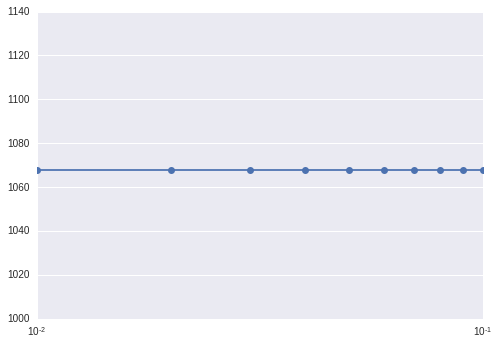

In [11]:
random_seed_list = [0,1268,845925,98,65465433,547812,9999999,8489465,25168,7415]
Al = np.linspace(0.01, 0.1, num=10)
res = []
for a in Al:
    # print a
    res.append(cv(Lasso(alpha=a,normalize=True), train, target, val_size=0.2, random_seed_list=random_seed_list))
plt.semilogx(Al, res,'-o');

Lasso is not helping

In [12]:
cols_for_dummies = ['Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
                    'Outlet_Type', 'Item_Type_Combined', 'Item_Outlet_Category']
train_dummy = pd.get_dummies(train, columns=cols_for_dummies)
test_dummy = pd.get_dummies(test, columns=cols_for_dummies)
cols_to_drop = ['Item_Fat_Content_2', 'Outlet_Identifier_9', 'Outlet_Size_2', 'Outlet_Location_Type_2',
        'Outlet_Type_3', 'Item_Type_Combined_2', 'Item_Outlet_Category_11']
train_dummy = train_dummy.drop(cols_to_drop, axis=1)
test_dummy = test_dummy.drop(cols_to_drop, axis=1)

In [13]:
lm = LinearRegression(normalize=True)
lm.fit(train_dummy, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

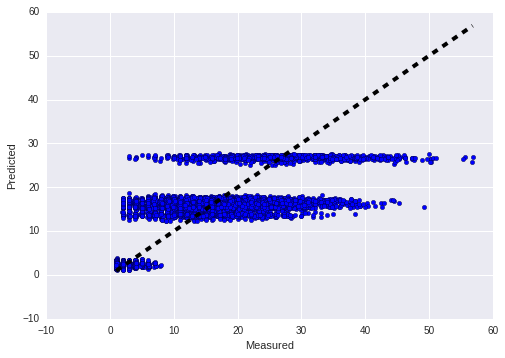

In [14]:
predicted = cross_val_predict(lm, train_dummy, target, cv=10)

fig, ax = plt.subplots()
ax.scatter(target, predicted)
ax.plot([target.min(), target.max()], [target.min(), target.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [15]:
print 'Train RMSE: {}'.format(mean_squared_error(target*train_dummy['Item_MRP'], lm.predict(train_dummy)*(train_dummy['Item_MRP'].values))**0.5)

Train RMSE: 1071.9311479


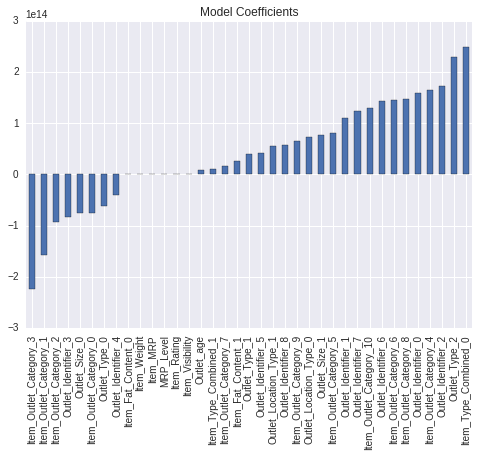

In [16]:
coef = pd.Series(lm.coef_, train_dummy.columns.values).sort_values()
coef.plot(kind='bar', title='Model Coefficients')

In [17]:
lm_preds = lm.predict(test_dummy)
submission = pd.read_csv('../input/SampleSubmission_TmnO39y.csv')
submission['Item_Outlet_Sales'] = lm_preds*test_dummy['Item_MRP']
submission.to_csv('../submissions/lm.csv', index=False)

In [18]:
# train_dummy = train_dummy.drop('Item_Weight', axis=1)
lr_sm = sm.OLS(target, train_dummy).fit()
print lr_sm.summary()

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     277.5
Date:                Fri, 09 Sep 2016   Prob (F-statistic):               0.00
Time:                        14:20:51   Log-Likelihood:                -28613.
No. Observations:                8523   AIC:                         5.727e+04
Df Residuals:                    8499   BIC:                         5.744e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Item_Weight               

1. Durbin-Watson is close to 2. Hence, no auto correlation.
2. Most of the p-values of variables are insignificant and hence they all contribute to regression. However, few variables have significant p-value. But removing them does not help.

In [19]:
# test_dummy = test_dummy.drop('Item_Weight', axis=1)
lr_preds = lr_sm.predict(test_dummy)
submission = pd.read_csv('../input/SampleSubmission_TmnO39y.csv')
submission['Item_Outlet_Sales'] = (lr_preds)*test['Item_MRP']
submission.to_csv('../submissions/lm_sm.csv', index=False)

## Submission scores around 1150 RMSE.